## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Get parent directory and add to sys.path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl for interactive plots
%matplotlib widget

In [2]:
# Import rocket and controllers
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis
from Deliverable_5_2.LinearMPC.MPCVelControl import MPCVelControl

# Paths to rocket parameters and 3D model
rocket_params_path = os.path.join(parent_dir, 'rocket.yaml')
rocket_obj_path = os.path.join(parent_dir, 'Cartoon_rocket.obj')

In [3]:
# Simulation parameters
Ts = 0.05  # Sampling time [s]
sim_time = 15  # Simulation duration [s]
H = 5.0  # MPC horizon [s]

# Initial state: [omega(3), theta(3), v(3), p(3)]
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])
x_target = np.zeros((12,))  # Target: all states to zero

# Create rocket and MPC controller
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Set variable mass parameters
rocket.mass = 2.0  # Initial mass [kg]
rocket.fuel_rate = 0.1  # Fuel consumption rate [kg/s]
# Initial fuel = rocket.mass / 2 = 1.0 kg
# Estimated fuel exhaustion time ≈ 10 seconds (depends on thrust profile)



t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, x_target=x_target, method='nonlinear'
)

# Extract final disturbance estimates
d_hat_x_final = mpc.mpc_x.d_hat[-1]
d_hat_y_final = mpc.mpc_y.d_hat[-1]
d_hat_z_final = mpc.mpc_z.d_hat[0]

# Extract results
vx_final = x_cl[6, -1]
vy_final = x_cl[7, -1]
vz_final = x_cl[8, -1]
v_norm_final = np.sqrt(vx_final**2 + vy_final**2 + vz_final**2)

# Compute mean velocities over last 2 seconds
last_2s = int(2.0 / Ts)
vx_mean = np.mean(x_cl[6, -last_2s:])
vy_mean = np.mean(x_cl[7, -last_2s:])
vz_mean = np.mean(x_cl[8, -last_2s:])
v_norm_mean = np.sqrt(vx_mean**2 + vy_mean**2 + vz_mean**2)

# Compute mass evolution (approximation from thrust history)
# Mass decreases based on fuel consumption: dm/dt = -fuel_rate * (u[2] / u_nominal)
mass_history = np.zeros(len(t_cl))
mass_history[0] = rocket.mass
for i in range(1, len(t_cl)):
    if i-1 < u_cl.shape[1]:
        fuel_consumed = rocket.fuel_rate * u_cl[2, i-1] * Ts / 50.0  # Normalized by nominal thrust
        mass_history[i] = max(rocket.mass/2, mass_history[i-1] - fuel_consumed)  # Don't go below dry mass
    else:
        mass_history[i] = mass_history[i-1]

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, Ref=ref[:,:-1], T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol); 


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



c:\Users\Julien Mangiatordi\.conda\envs\mpc2025\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:30: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


 Z-controller: d=0.0000 requires u=-0.00N, saturated to [40.0, 80.0] → u_ss=40.00N
Fuel left: 1.00 kg, 
 Z-controller: d=-0.1527 requires u=20.76N, saturated to [40.0, 80.0] → u_ss=40.00N
Fuel left: 1.00 kg, 
Fuel left: 0.99 kg, 
Fuel left: 0.99 kg, 

 State beta violation: -0.20 < -0.17, 
 State alpha violation: 0.20 > 0.17, Fuel left: 0.99 kg, 

 State beta violation: -0.30 < -0.17, 
 State alpha violation: 0.31 > 0.17, Fuel left: 0.99 kg, 

 State beta violation: -0.39 < -0.17, 
 State alpha violation: 0.41 > 0.17, Fuel left: 0.99 kg, 

 State beta violation: -0.45 < -0.17, 
 State alpha violation: 0.49 > 0.17, Fuel left: 0.98 kg, 

 State beta violation: -0.48 < -0.17, 
 State alpha violation: 0.54 > 0.17, Fuel left: 0.98 kg, 

 State beta violation: -0.50 < -0.17, 
 State alpha violation: 0.57 > 0.17, Fuel left: 0.98 kg, 

 State beta violation: -0.49 < -0.17, 
 State alpha violation: 0.56 > 0.17, Fuel left: 0.98 kg, 

 State beta violation: -0.46 < -0.17, 
 State alpha violation:

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

---
## Visualization and Analysis

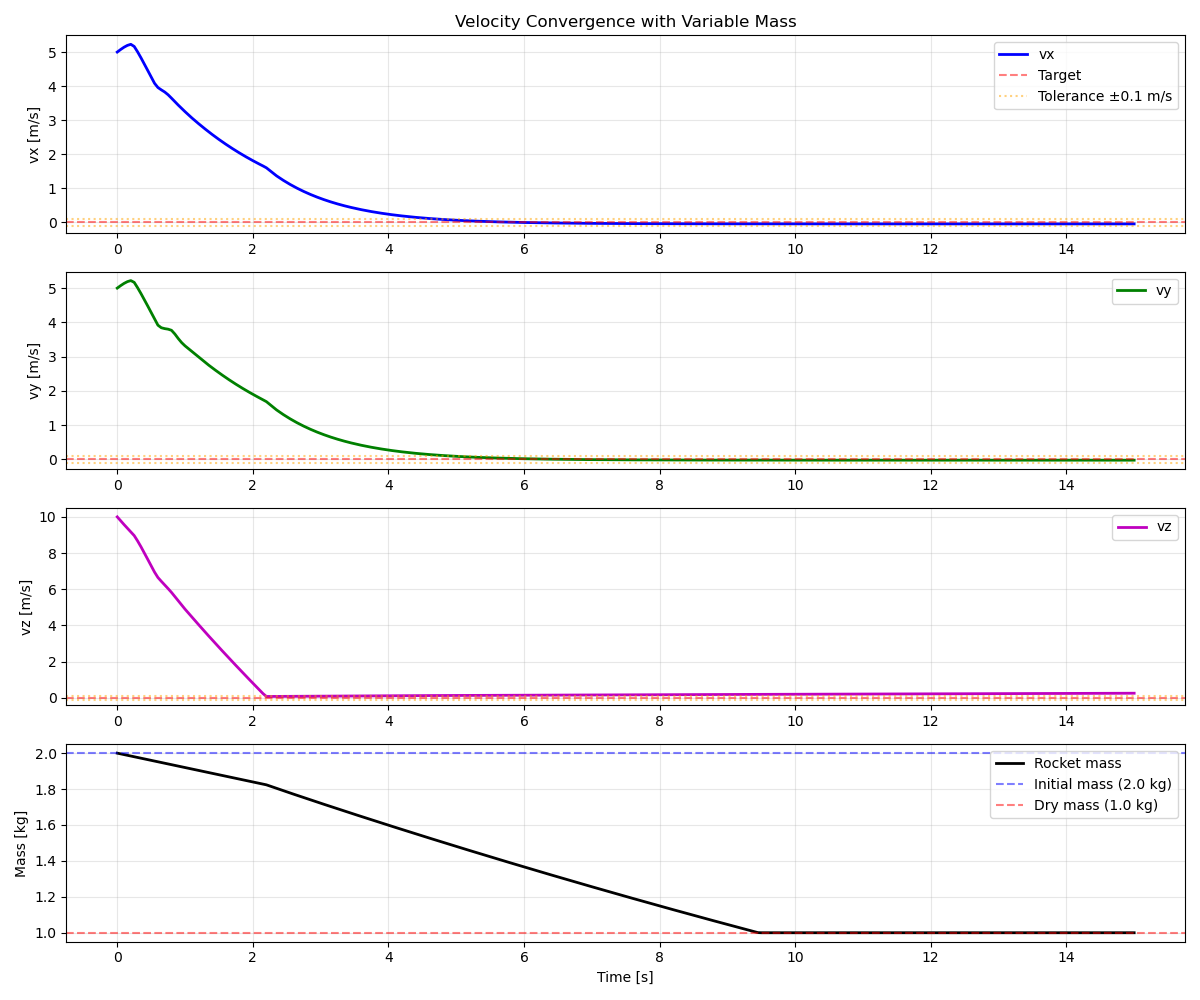

In [4]:
# Plot 1: Velocity convergence with mass overlay
fig1, axes1 = plt.subplots(4, 1, figsize=(12, 10))

# vx
axes1[0].plot(t_cl, x_cl[6, :], 'b-', linewidth=2, label='vx')
axes1[0].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Target')
axes1[0].axhline(y=0.1, color='orange', linestyle=':', alpha=0.5, label='Tolerance ±0.1 m/s')
axes1[0].axhline(y=-0.1, color='orange', linestyle=':', alpha=0.5)
axes1[0].set_ylabel('vx [m/s]')
axes1[0].set_title('Velocity Convergence with Variable Mass')
axes1[0].legend(loc='upper right')
axes1[0].grid(True, alpha=0.3)

# vy
axes1[1].plot(t_cl, x_cl[7, :], 'g-', linewidth=2, label='vy')
axes1[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes1[1].axhline(y=0.1, color='orange', linestyle=':', alpha=0.5)
axes1[1].axhline(y=-0.1, color='orange', linestyle=':', alpha=0.5)
axes1[1].set_ylabel('vy [m/s]')
axes1[1].legend(loc='upper right')
axes1[1].grid(True, alpha=0.3)

# vz
axes1[2].plot(t_cl, x_cl[8, :], 'm-', linewidth=2, label='vz')
axes1[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes1[2].axhline(y=0.1, color='orange', linestyle=':', alpha=0.5)
axes1[2].axhline(y=-0.1, color='orange', linestyle=':', alpha=0.5)
axes1[2].set_ylabel('vz [m/s]')
axes1[2].legend(loc='upper right')
axes1[2].grid(True, alpha=0.3)

# Mass evolution
axes1[3].plot(t_cl, mass_history, 'k-', linewidth=2, label='Rocket mass')
axes1[3].axhline(y=rocket.mass, color='b', linestyle='--', alpha=0.5, label=f'Initial mass ({rocket.mass:.1f} kg)')
axes1[3].axhline(y=rocket.mass/2, color='r', linestyle='--', alpha=0.5, label=f'Dry mass ({rocket.mass/2:.1f} kg)')
axes1[3].set_ylabel('Mass [kg]')
axes1[3].set_xlabel('Time [s]')
axes1[3].legend(loc='upper right')
axes1[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

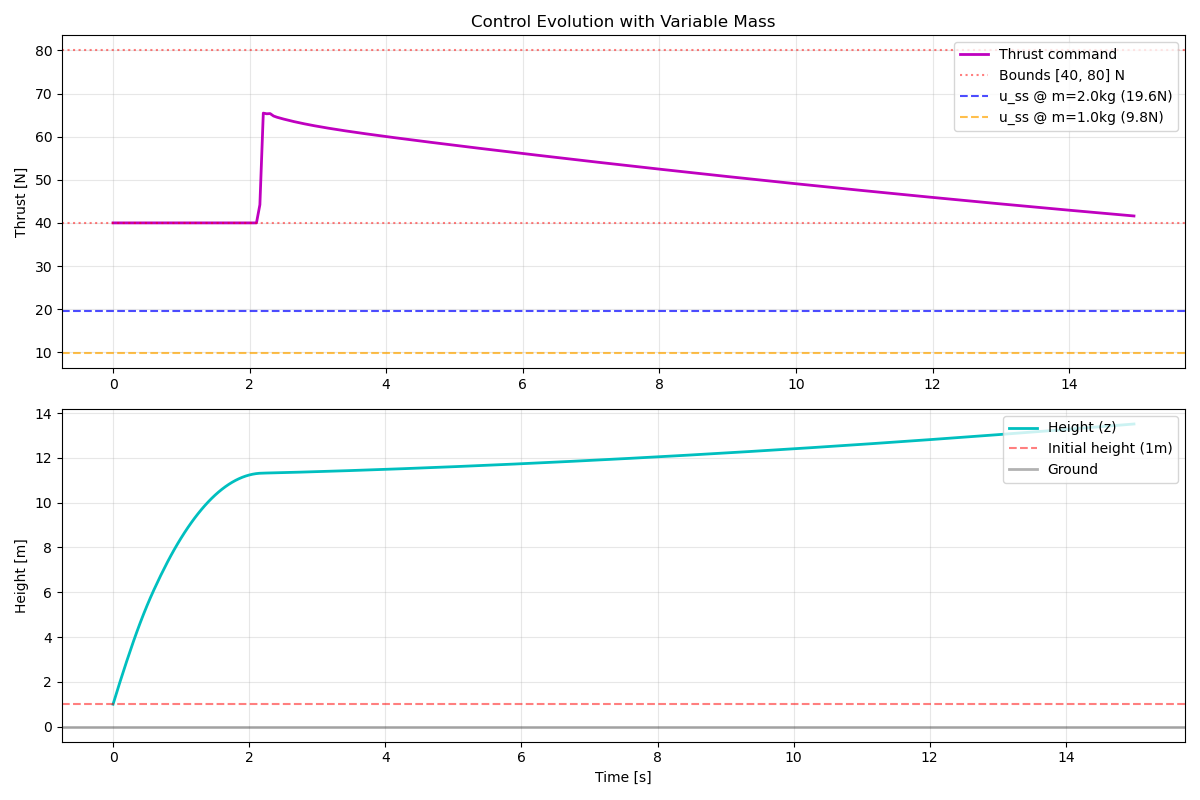

In [5]:
# Plot 2: Thrust and height with phases
fig2, axes2 = plt.subplots(2, 1, figsize=(12, 8))

# Thrust command
axes2[0].plot(t_cl[:-1], u_cl[2, :], 'm-', linewidth=2, label='Thrust command')
axes2[0].axhline(y=40, color='r', linestyle=':', alpha=0.5, label='Bounds [40, 80] N')
axes2[0].axhline(y=80, color='r', linestyle=':', alpha=0.5)
# Expected steady-state thrust for gravity compensation at different masses
u_ss_initial = rocket.mass * 9.806  # Initial mass
u_ss_final = (rocket.mass/2) * 9.806  # Dry mass
axes2[0].axhline(y=u_ss_initial, color='b', linestyle='--', alpha=0.7, label=f'u_ss @ m={rocket.mass:.1f}kg ({u_ss_initial:.1f}N)')
axes2[0].axhline(y=u_ss_final, color='orange', linestyle='--', alpha=0.7, label=f'u_ss @ m={rocket.mass/2:.1f}kg ({u_ss_final:.1f}N)')
axes2[0].set_ylabel('Thrust [N]')
axes2[0].set_title('Control Evolution with Variable Mass')
axes2[0].legend(loc='upper right')
axes2[0].grid(True, alpha=0.3)

# Height (z position)
axes2[1].plot(t_cl, x_cl[11, :], 'c-', linewidth=2, label='Height (z)')
axes2[1].axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Initial height (1m)')
axes2[1].axhline(y=0, color='k', linestyle='-', linewidth=2, alpha=0.3, label='Ground')
axes2[1].set_ylabel('Height [m]')
axes2[1].set_xlabel('Time [s]')
axes2[1].legend(loc='upper right')
axes2[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

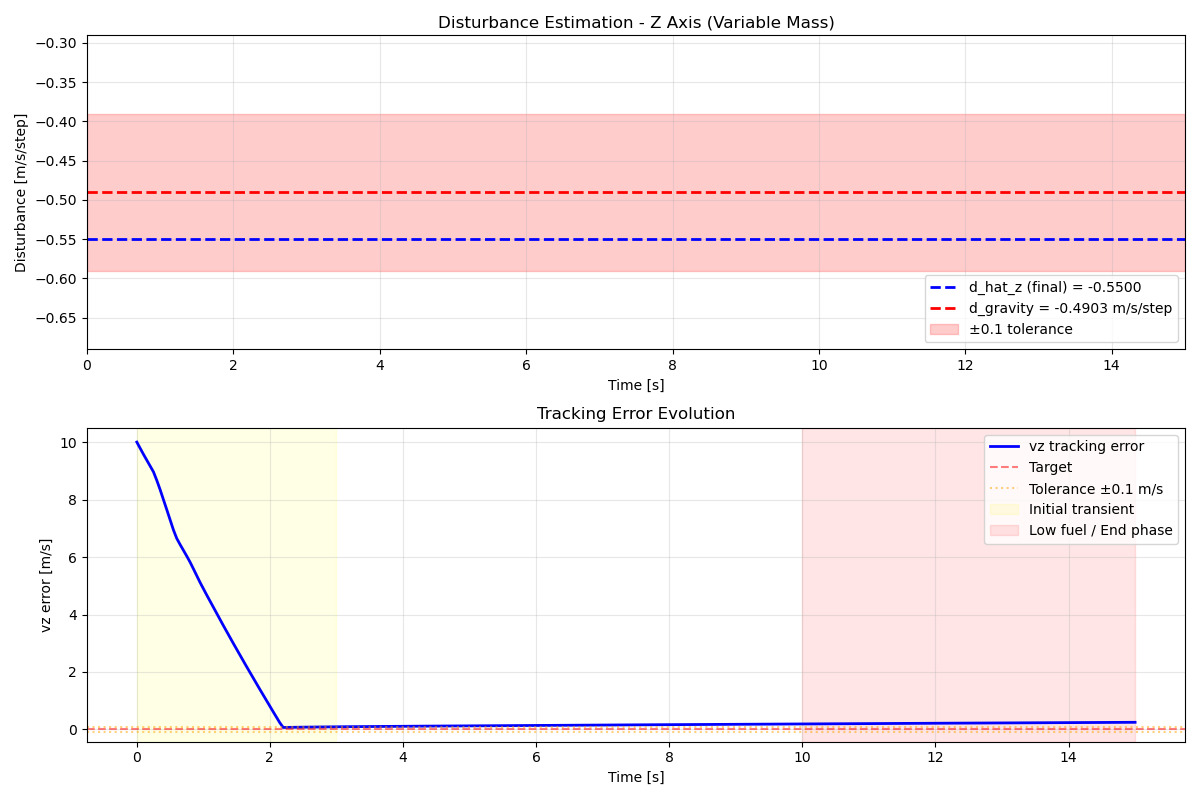

In [6]:
# Plot 3: Disturbance estimation vs actual disturbance
fig3, axes3 = plt.subplots(2, 1, figsize=(12, 8))

# Compute actual disturbance (time-varying due to changing mass)
# For Z-axis: d_actual = -g * Ts (constant gravity)
d_gravity = -9.806 * Ts  # True constant gravity disturbance

# Subplot 1: Final disturbance estimates
axes3[0].axhline(y=d_hat_z_final, color='b', linestyle='--', linewidth=2, label=f'd_hat_z (final) = {d_hat_z_final:.4f}')
axes3[0].axhline(y=d_gravity, color='r', linestyle='--', linewidth=2, label=f'd_gravity = {d_gravity:.4f} m/s/step')
axes3[0].fill_between([0, t_cl[-1]], d_gravity-0.1, d_gravity+0.1, alpha=0.2, color='red', label='±0.1 tolerance')
axes3[0].set_ylabel('Disturbance [m/s/step]')
axes3[0].set_xlabel('Time [s]')
axes3[0].set_title('Disturbance Estimation - Z Axis (Variable Mass)')
axes3[0].legend(loc='lower right')
axes3[0].grid(True, alpha=0.3)
axes3[0].set_xlim([0, t_cl[-1]])
axes3[0].set_ylim([d_gravity-0.2, max(d_hat_z_final, d_gravity)+0.2])

# Subplot 2: Tracking error in vz
vz_error = x_cl[8, :]
axes3[1].plot(t_cl, vz_error, 'b-', linewidth=2, label='vz tracking error')
axes3[1].axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Target')
axes3[1].axhline(y=0.1, color='orange', linestyle=':', alpha=0.5, label='Tolerance ±0.1 m/s')
axes3[1].axhline(y=-0.1, color='orange', linestyle=':', alpha=0.5)
# Annotate different phases
axes3[1].axvspan(0, 3, alpha=0.1, color='yellow', label='Initial transient')
if t_cl[-1] > 10:
    axes3[1].axvspan(max(0, t_cl[-1]-5), t_cl[-1], alpha=0.1, color='red', label='Low fuel / End phase')
axes3[1].set_ylabel('vz error [m/s]')
axes3[1].set_xlabel('Time [s]')
axes3[1].set_title('Tracking Error Evolution')
axes3[1].legend(loc='upper right')
axes3[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
